In [1]:
import os
import pandas as pd 
import numpy as np

import tensorflow 
from tensorflow import keras
from keras.models import Model
from keras import layers, regularizers

import cv2 #images

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## import dependencies for model
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.metrics import classification_report, confusion_matrix

In [14]:
import json

with open('config.json', 'r') as config_file:
    config = json.load(config_file)

DB_HOST = config["DB_HOST"]
DB_NAME = config["DB_NAME"]
DB_USER = config["DB_USER"]
DB_PASS = config["DB_PASS"]


In [4]:
import psycopg2

# Connect to the database
try:
    connection = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = connection.cursor()
    
    # Create table for the new dataset
    create_table_query = """
    CREATE TABLE IF NOT EXISTS skin_cancer_images (
        id SERIAL PRIMARY KEY,
        file_path TEXT,
        label TEXT,
        image_data BYTEA
    );
    """
    
    cursor.execute(create_table_query)
    connection.commit()
    print("Table 'skin_cancer_images' created successfully.")

except Exception as e:
    print(f"An error occurred while creating the table: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'connection' in locals():
        connection.close()

Table 'skin_cancer_images' created successfully.


In [5]:
import os
import pandas as pd
import psycopg2
import json


# Define paths for the new dataset directories
dataset_dirs = [
    '/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Skin-Cancer-Detection-Project-4-JT/dataset/HAM10000_images_part_1',
    '/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Skin-Cancer-Detection-Project-4-JT/dataset/HAM10000_images_part_2'
]

# Load the metadata
metadata = pd.read_csv('/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Skin-Cancer-Detection-Project-4-JT/dataset/HAM10000_metadata.csv')

# Create a dictionary mapping image_id to diagnosis
label_dict = pd.Series(metadata['dx'].values, index=metadata['image_id']).to_dict()

# ?????? # Create Label Dict
# labels = {0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
#          1:('bcc' , ' basal cell carcinoma'),
#          2 :('bkl', 'benign keratosis-like lesions'),
#          3: ('df', 'dermatofibroma'),
#          4: ('nv', ' melanocytic nevi'),
#          5: ('vasc', ' pyogenic granulomas and hemorrhage'),
#         6: ('mel', 'melanoma')}

# Collect image paths and labels into a list
data = []
for dataset_dir in dataset_dirs:
    for filename in os.listdir(dataset_dir):
        if filename.endswith('.jpg'):
            file_path = os.path.join(dataset_dir, filename)
            image_id = filename.split('.')[0]  # Extract image ID from filename (e.g., 'ISIC_0029306' from 'ISIC_0029306.jpg')
            label = label_dict.get(image_id, 'unknown')  # Retrieve label from metadata, defaulting to 'unknown' if not found
            data.append({'file_path': file_path, 'label': label})

# Function to read and resize an image as binary data
def resize_image(file_path):
    img = cv2.imread(file_path)
    resized_img = cv2.resize(img, (224, 224))  # Resize to smaller dimensions
    return resized_img

# Function to read image as binary data
def read_image_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Insert images into the SQL database
try:
    connection = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = connection.cursor()

    for record in data:
        # Resize the image before reading it as binary data
        resized_img = resize_image(record['file_path'])
        image_data = cv2.imencode('.jpg', resized_img)[1].tobytes()  # Encode the resized image as binary data
        
        insert_query = """
        INSERT INTO skin_cancer_images (file_path, label, image_data) VALUES (%s, %s, %s);
        """
        cursor.execute(insert_query, (record['file_path'], record['label'], psycopg2.Binary(image_data)))

    connection.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred while inserting data: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'connection' in locals():
        connection.close()

Data inserted successfully.


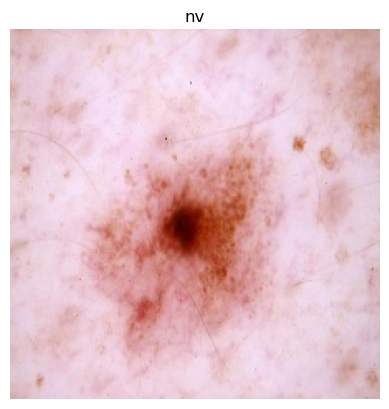

In [6]:
import psycopg2
from PIL import Image
import io
import matplotlib.pyplot as plt

try:
    connection = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = connection.cursor()

    # Query to select the first image record
    cursor.execute("SELECT label, image_data FROM skin_cancer_images LIMIT 1;")
    row = cursor.fetchone()

    if row:
        label, image_data = row
        # Convert binary data back into an image and display it
        image = Image.open(io.BytesIO(image_data))
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
        plt.show()
    else:
        print("No data found in the table.")

except Exception as e:
    print(f"An error occurred while retrieving images: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'connection' in locals():
        connection.close()

In [ ]:
# Split the DataSet
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, label, test_size=0.05, random_state=42)

In [ ]:
# Build CNN (conv neural network) Model 

In [ ]:
def model(input_shape=(224, 224, 3), num_classes=1000):
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model



In [ ]:
model.compile(optimizer='adam',loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [ ]:
model.summary()

In [ ]:
#Training our CNN Model
class_weights = {0:1,1:0.5,2:1,3:1,4:1,5:1,6:1}
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=90, class_weight=class_weights,validation_data=(y_train, y_test))

In [ ]:
# Make Predictions
predictions=model.predict_classes(y_train)

check=[]
for i in range(len(y_test)):
  for j in range(7):
    if(y_test[i][j]==1):
      check.append(j)
check=np.asarray(check)

print(classification_report(check, predictions))

In [ ]:
model.save('modelv1.h5')